# Barycenter Computation with PDLP (raPDHG)

This notebook computes a discrete Wasserstein barycenter on a 2D grid using the PDLP barycenter solver.
The grid size is kept small to keep the cost matrix manageable.


In [1]:
import sys, os
from jax import config

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'
config.update('jax_enable_x64', True)
sys.path.insert(0, os.path.abspath(os.path.join('..')))

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from uot.data.measure import DiscreteMeasure
from uot.utils.costs import cost_euclid_squared
from uot.solvers.pdlp_barycenter import PDLPBarycenterSolver
from uot.problems.generators.toy_barycenter_generator import ToyBarycenterGenerator, FixedListSelector


In [2]:
selector = FixedListSelector(('Ring', 'Crescent', 'Checker'))
gen = ToyBarycenterGenerator(
    selector=selector,
    n_points=64,
    cost_fn=cost_euclid_squared,
    num_datasets=1,
    measure_mode='grid',
)
problem = next(gen.generate(num_marginals=3))
measures = problem.get_marginals()


In [7]:
support, weights, cost_matrix, lambdas = problem.shared_support_inputs(
    mode='union',
    include_zeros=True,
)

marginals = [
    DiscreteMeasure(points=support, weights=weights[i], name=f'measure_{i+1}')
    for i in range(weights.shape[0])
]

solver = PDLPBarycenterSolver()
result = solver.solve(
    marginals=marginals,
    costs=[cost_matrix],
    weights=lambdas,
)
barycenter = result['barycenter']


In [4]:
grid_shape = None
if hasattr(measures[0], 'weights_nd'):
    grid_shape = np.asarray(measures[0].weights_nd).shape

shape_fields = []
for measure in measures:
    if hasattr(measure, 'weights_nd'):
        shape_fields.append(np.asarray(measure.weights_nd))
    else:
        _, w = measure.to_discrete(include_zeros=True)
        shape_fields.append(np.asarray(w).reshape(grid_shape))

if grid_shape is None:
    raise ValueError('Expected grid-shaped measures for plotting')
barycenter_field = np.asarray(barycenter).reshape(grid_shape)


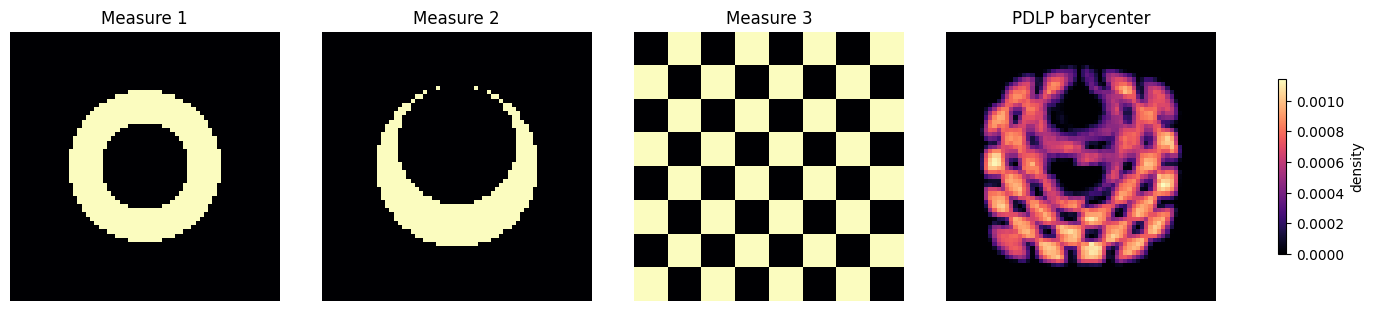

In [5]:
fig, axarr = plt.subplots(1, len(shape_fields) + 1, figsize=(14, 3), constrained_layout=True)
titles = [f'Measure {i+1}' for i in range(len(shape_fields))] + ['PDLP barycenter']
fields = shape_fields + [barycenter_field]
for ax, title, field in zip(axarr, titles, fields):
    im = ax.imshow(field, origin='lower', cmap='magma')
    ax.set_title(title)
    ax.axis('off')
fig.colorbar(im, ax=axarr.tolist(), shrink=0.65, label='density')
